# 目标检测——iou、giou、ciou总结

## 一、IOU  
1.iou定义：真实框与预测框的交集与真实框与预测框的并集的比值  
2.图像呈现：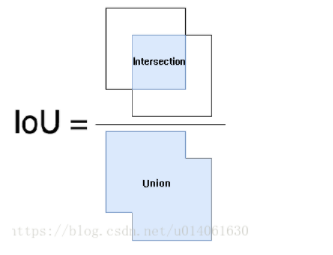  
3.在faster_rcnn中，使用smooth_l1作为框的损失函数，而我们在衡量框好坏的时候，计算的iou，存在一定的不一致性，所以我们希望将IOU作为loss来优化距离；IOU_LOSS = 1-IOU，当IOU越大时，表明框重合度越高，1-IOU越小，即loss越小。  
4.IOU LOSS缺点：  
（1）当两个框不相交时，IOU=0,LOSS=1,进行反向传播，当两个框相距较远时，调整预测框位置后，IOU仍为零，这样导致多次调整后，LOSS仍为1， 这样网络需要很多次迭代（随机尝试），才有可能产生交集，进而不断缩小loss  
（2）loss仅仅与两个框的交并比相关，但交并比相同，可能重合程度并不一样，即IoU无法区分两个对象之间不同的对齐方式。如下图：  
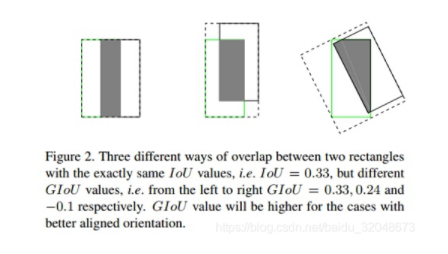

In [1]:
# IOU代码实现
def calculate_iou(_box_a, _box_b):
    # 真实框更换坐标
    b1_x1, b1_x2 = _box_a[:, 0] - _box_a[:, 2]/2, _box_a[:, 0] + _box_a[:, 2]/2
    b1_y1, b1_y2 = _box_a[:, 1] - _box_a[:, 3]/2, _box_a[:, 1] + _box_a[:, 3]/2
    # 先验框更换坐标
    b2_x1, b2_x2 = _box_b[:, 0] - _box_b[:, 2]/2, _box_b[:, 0] + _box_b[:, 2]/2
    b2_y1, b2_y2 = _box_b[:, 1] - _box_b[:, 3]/2, _box_b[:, 1] + _box_b[:, 3]/2
    box_a = torch.zeros_like(_box_a)
    box_b = torch.zeros_like(_box_b)
    box_a[:, 0], box_a[:, 1], box_a[:, 2], box_a[:, 3] = b1_x1, b1_y1, b1_x2, b1_y2
    box_b[:, 0], box_b[:, 1], box_b[:, 2], box_b[:, 3] = b2_x1, b2_y1, b2_x2, b2_y2
    # 确定真实框与先验框的数量
    A = box_a.shape[0]
    B = box_b.shape[0]
    # 计算交的面积
    max_xy = torch.min(box_a[:, 2:4].unsqueeze(1).expand(A, B, 2), box_b[:, 2:4].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, 0:2].unsqueeze(1).expand(A, B, 2), box_b[:, 0:2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy-min_xy), min=0)
    inter = inter[:, :, 0]*inter[:, :, 1]
    # 计算真实框与先验框各自的面积
    area_a = ((box_a[:, 2]-box_a[:, 0])*(box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)
    area_b = ((box_b[:, 2]-box_b[:, 0])*(box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)
    union = area_a + area_b - inter
    return inter/union

## 二、GIOU

1.针对IOU LOSS的缺点进行优化，增加相应的惩罚项，如GIOU  
2.公式：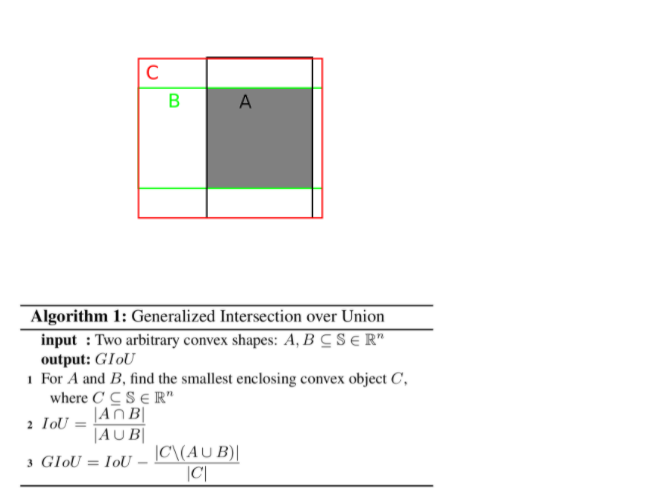  
3.优点：GIOU考虑到了IOU没有考虑到的非重叠区域，能够反应出A,B重叠的方式

In [2]:
# giou代码实现
def box_giou(b1, b2):
    # 转成左上角右下角
    b1_xy = b1[..., 0:2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh / 2
    b1_mins = b1_xy-b1_wh_half
    b1_maxes = b1_xy+b1_wh_half
    b2_xy = b2[..., 0:2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2
    b2_mins = b2_xy-b2_wh_half
    b2_maxes = b2_xy+b2_wh_half
    # 求真实框和预测框所有iou
    intersect_maxes = torch.min(b1_maxes, b2_maxes) # 注意torch.max(tensor1, tensor2)代表按元素求最大或最小
    intersect_mins = torch.max(b1_mins, b2_mins)
    intersect_wh = torch.max(intersect_maxes-intersect_mins, torch.zeros_like(intersect_maxes))
    intersect_area = intersect_wh[..., 0]*intersect_wh[..., 1]
    b1_area = b1_wh[..., 0]*b1_wh[..., 1]
    b2_area = b2_wh[..., 0]*b2_wh[..., 1]
    union_area = b1_area+b2_area-intersect_area
    iou = intersect_area/union_area
    # 计算giou
    enclose_mins = torch.min(b1_mins, b2_mins)
    enclose_maxes = torch.max(b1_maxes, b2_maxes)
    enclose_wh = torch.max(enclose_maxes-enclose_mins, torch.zeros_like(enclose_maxes))
    enclose_area = enclose_wh[..., 0]*enclose_wh[..., 1]
    giou = iou - (enclose_area-union_area)/enclose_area
    return giou

## 三、DIOU  
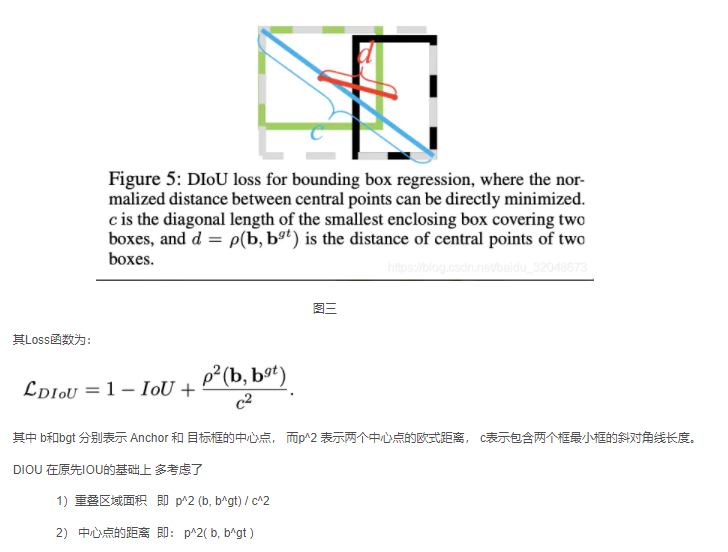  
2.优点：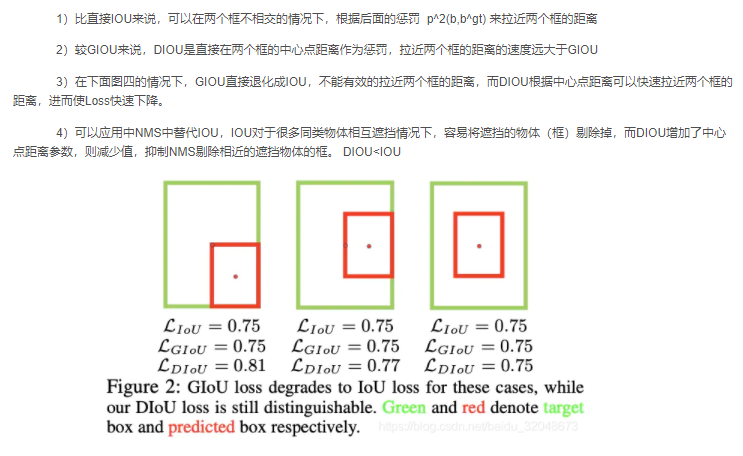

## 四、CIOU
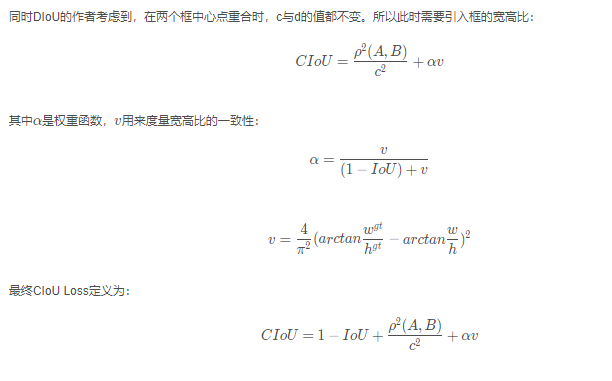

In [4]:
# ciou
def box_ciou(b1, b2):
    # b1, b2 [batch, anchor_num, f_h, f_w, 4]
    # 预测框
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh / 2
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half
    # 真实框
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half
    # 求iou
    intersect_mins = torch.max(b1_mins, b2_mins)
    intersect_maxes = torch.min(b1_maxes, b2_maxes)
    intersect_wh = torch.max(intersect_maxes-intersect_mins, torch.zeros_like(intersect_maxes))
    intersect_area = intersect_wh[..., 0]*intersect_wh[..., 1]
    b1_area = b1_wh[..., 0]*b1_wh[..., 1]
    b2_area = b2_wh[..., 0]*b2_wh[..., 1]
    union_area = b1_area+b2_area-intersect_area
    iou = intersect_area/torch.clamp(union_area, min=1e-6)
    # 计算中心距离
    center_distance = torch.sum(torch.pow((b1_xy-b2_xy), 2), dim=-1)
    # 找到包裹两个框的最小框的左上角与右下角
    enclose_mins = torch.min(b1_mins, b2_mins)
    enclose_maxes = torch.max(b1_maxes, b2_maxes)
    enclose_wh = torch.max(enclose_maxes-enclose_mins, torch.zeros_like(enclose_maxes))
    # 计算对角线距离
    enclose_diagonal = torch.sum(torch.pow(enclose_wh, 2), dim=-1)
    ciou = iou - 1.0*(center_distance)/(torch.clamp(enclose_diagonal, min=1e-6))
    v = (4 / (math.pi ** 2)) * torch.pow((torch.atan(b1_wh[..., 0] / torch.clamp(b1_wh[..., 1], min=1e-6)) - torch.atan(b2_wh[..., 0] / torch.clamp(b2_wh[..., 1], min=1e-6))), 2)
    alpha = v / torch.clamp((1.0 - iou + v), min=1e-6)
    ciou = ciou - alpha*v
    return ciou